## Viscoelastic isotropic marmousi model
###### Qi Hao, Apr. 30, 2021

In [1]:
# Import Libraries 
# ----------------
import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from pylab import rcParams
# from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
## Import my py_plot functions in file: pltfuns.py
from pltfuns import *

In [3]:
# Ignore Warning Messages
# -----------------------
import warnings
warnings.filterwarnings("ignore")

import time as tm

import os

In [4]:
### folder name for the output figs
if not os.path.exists('./figs'):
    os.makedirs('./figs')

if not os.path.exists('./model_out'):
    os.makedirs('./model_out')

In [5]:
### --------------------------------------------
def plot_data(data, nz, nx, dz, dx, oz=0, ox=0, zlab="", xlab="", \
              alpha=0, clip=1, vrange=None, asp=2, allpos=False, bar=True, barlab="", barhorn=False, \
              shnk=0.7, fsize=(7,7), color="jet", title="", fname=""):
    
    if allpos:
        min_val = np.min(data)
        max_val = np.max(data)
        ### Clip and scale data at fraction of [min, max]
        data2   = np.clip(data,-clip*max_val,clip*max_val)
    else:
        max_val = np.max(np.abs(data))
        min_val = - max_val
         ### Clip and scale data at fraction of [-max, max]
        data2   = np.clip(data, clip*min_val, clip*max_val)

    ### gain the data along the vertical axis. This is used to illustrate seismogram better.
    scale = (np.arange(nz)*dz)**alpha    
    data2 = data2 * scale[:, None]
    
    plt.figure(figsize=fsize)
    #plt.subplots_adjust(left=0.1, bottom=0.1, top=0.9, right=0.9)    
    
    if vrange != None:
        image = plt.imshow(data2,vmin=vrange[0],vmax=vrange[1], \
                           extent=[ox, (nx-1)*dx, (nz-1)*dz,oz], aspect=asp, cmap=color)
    else: 
        image = plt.imshow(data2,vmin=min_val*clip,vmax=max_val*clip, \
                           extent=[ox, (nx-1)*dx, (nz-1)*dz,oz], aspect=asp, cmap=color)
        
    if title.strip():
        ### title, as the argument for the plot tile, is a string. 
        ### If it is empty (such as "" or "  "), it.strip() is false.
        plt.title(title)
    
    if barhorn:
        barorien = "horizontal"
    else:
        barorien = "vertical"
        
    if bar:
        if barlab.strip():
#             plt.colorbar(image, shrink=shnk, label=barlab, orientation=barorien)
            cb = plt.colorbar(image, shrink=shnk, orientation=barorien)
            cb.set_label(label=barlab, size=14)
        else:
            plt.colorbar(image, shrink=shnk)
    
    plt.xlim(ox, (nx-1)*dx)
    plt.ylim((nz-1)*dz, oz)
    
    plt.xlabel(xlab, fontsize=14)
    plt.ylabel(zlab, fontsize=14)
    
    if fname.strip():
        plt.savefig(fname, format="pdf", dpi=800, bbox_inches="tight")
        
    plt.show()
    plt.close()

In [6]:
################ Read Marmousi velocity and 1/Q files ###########################
nx_marm = 737
nz_marm = 240
## read Marmousi model
# vel_tmp = np.loadtxt("./vp_marm.txt")
# vel_tmp = np.array(vel_tmp)
# vel_tmp2 = np.reshape(vel_tmp, (nx_marm,nz_marm))
# vel_tmp2 = np.transpose(vel_tmp2)

vel_tmp = np.fromfile("./in/vmarm_small.bin", dtype=np.float32)
vel_tmp = vel_tmp.astype('float64') 
vel_tmp = vel_tmp.reshape((nx_marm, nz_marm))
vel_tmp = vel_tmp.transpose()

In [7]:
# Definition of modelling parameters

dx   = 0.005     # grid point distance in x-direction (km)
dz   = dx        # grid point distance in z-direction (km)

n_absorb = 40    ## PML layer grid number

In [8]:
vmin = vel_tmp.min()
vmax = vel_tmp.max()

In [9]:
vtop = vel_tmp[0,:]
vbot = vel_tmp[-1,:]

In [10]:
vtop_layer = np.tile(vtop, (n_absorb,1))
vbot_layer = np.tile(vbot, (n_absorb,1))

In [11]:
vtop_layer.shape

(40, 737)

In [12]:
vbot_layer.shape

(40, 737)

In [13]:
vel = np.vstack((vtop_layer, vel_tmp, vbot_layer))

In [14]:
#### smoothing 
import scipy.ndimage as ndimg

# # Arbitrary weights
# weights = np.array([[0, 0, 1, 0, 0],
#                     [0, 2, 4, 2, 0],
#                     [1, 4, 8, 4, 1],
#                     [0, 2, 4, 2, 0],
#                     [0, 0, 1, 0, 0]],
#                    dtype=np.float)
# weights = weights / np.sum(weights[:])

# veltop = ndimg.filters.convolve(vel[:40,:], weights)
# velbot = ndimg.filters.convolve(vel[-40:,:], weights)

veltop = ndimg.filters.gaussian_filter(vel[:40,:], sigma=[15,15])
velbot = ndimg.filters.gaussian_filter(vel[-40:,:], sigma=[15,15])

In [15]:
vel[:n_absorb,:]  = veltop
vel[-n_absorb:,:] = velbot

In [16]:
nx=nx_marm
nz=nz_marm + 2*n_absorb

print("(nx,nz)=",(nx,nz))

(nx,nz)= (737, 320)


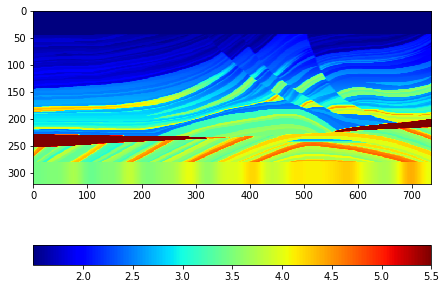

In [17]:
plot_check_model(vel, nz, nx)

In [18]:
### P-wave velocity model
vp0 = vel

### S-wave velocity model
vs0 = vel / 2

iQpmax = 1/100
iQpmin = 0

iQp0 = iQpmax - (iQpmax-iQpmin)*(vel-vmin)/(vmax-vmin) 

iQsmax = 1/70
iQsmin = 0

iQs0 = iQsmax - (iQsmax-iQsmin)*(vel-vmin)/(vmax-vmin) 

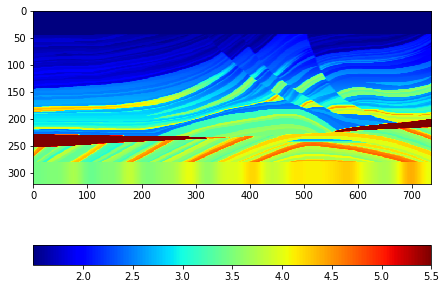

In [19]:
## plot the vp0 model
plot_check_model(vp0, nz, nx)

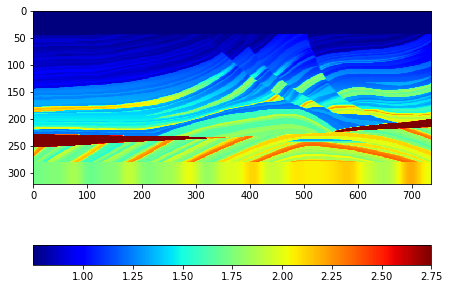

In [20]:
## plot the vs0 model
plot_check_model(vs0, nz, nx)

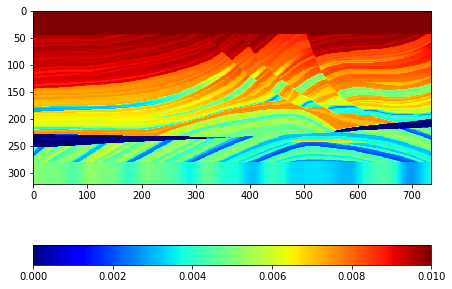

In [21]:
## plot 1/Qp0 model
plot_check_model(iQp0, nz, nx)

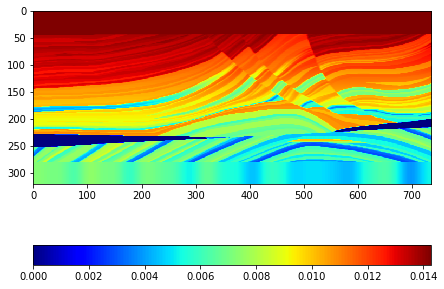

In [22]:
## plot 1/Qps model
plot_check_model(iQs0, nz, nx)

In [23]:
#### save seismogram to npy-format file
fout = "./model_out/vp0_model.npy"
np.save(fout, vp0)

fout = "./model_out/vs0_model.npy"
np.save(fout, vs0)

fout = "./model_out/Ap0_model.npy"
np.save(fout, iQp0)

fout = "./model_out/As0_model.npy"
np.save(fout, iQs0)

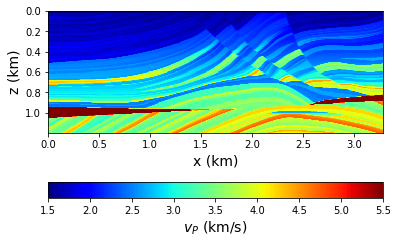

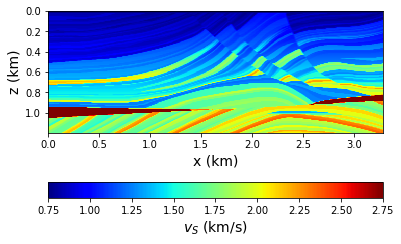

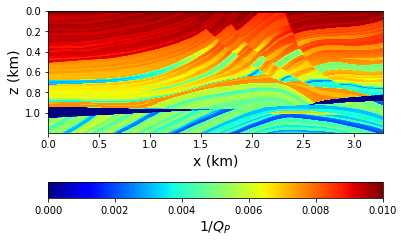

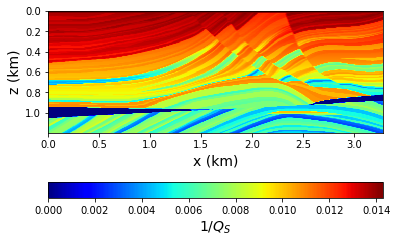

In [24]:
#### plot the models without absorbing boundary layers
nz_range = nz - 2*n_absorb
nx_range = nx - 2*n_absorb

plot_data(vp0[n_absorb:nz-n_absorb, n_absorb:nx-n_absorb], nz_range, nx_range, dz, dx, \
          zlab='z (km)', xlab='x (km)',alpha=0, vrange=[1.5,5.5], barlab="$v_{P}$ (km/s)", barhorn=True, shnk=1, fsize=(6, 6), \
          asp=1, allpos=True, color='jet', fname='./figs/vp_noPML.pdf')

plot_data(vs0[n_absorb:nz-n_absorb, n_absorb:nx-n_absorb], nz_range, nx_range, dz, dx, \
          zlab='z (km)', xlab='x (km)',alpha=0, vrange=[0.75,2.75], barlab="$v_{S}$ (km/s)", barhorn=True, shnk=1, fsize=(6, 6), \
          asp=1, allpos=True, color='jet', fname='./figs/vs_noPML.pdf')

plot_data(iQp0[n_absorb:nz-n_absorb, n_absorb:nx-n_absorb], nz_range, nx_range, dz, dx, \
          zlab='z (km)', xlab='x (km)', alpha=0, barlab="$1/Q_{P}$", barhorn=True, shnk=1, fsize=(6, 6), \
          asp=1, allpos=True, color='jet', fname='./figs/iQp_noPML.pdf')

plot_data(iQs0[n_absorb:nz-n_absorb, n_absorb:nx-n_absorb], nz_range, nx_range, dz, dx, \
          zlab='z (km)', xlab='x (km)', alpha=0, barlab="$1/Q_{S}$", barhorn=True, shnk=1, fsize=(6, 6), \
          asp=1, allpos=True, color='jet', fname='./figs/iQs_noPML.pdf')